- Recombine the final sequece and croos over between the weak links -> needed a custum function, maybe full deterministic
- Stats and dataframe for the SNP and other variants
- Implement gaps NNNNN

In [22]:
# Implementation using tensors
import tensorflow as tf


read_1 = "ATTTAggggTA"
read_1 = read_1.upper()

read_2 = "ATTCGGATCGA"
read_2 = read_2.upper()

read_tf_2 = tf.constant([ord(c) for c in read_2])
read_tf_1 = tf.constant([ord(c) for c in read_1])
read_tf_1.get_shape()[0]
# read_tf = tf.strings.unicode_encode(read_tf, "UTF-8")

for i in range(read_tf_1.get_shape()[0]):
    print(i)

TypeError: 'float' object cannot be interpreted as an integer

### Here trying parallelization with Numba e prange

[2024-05-08 09:12:19.863822]: There are 8 bases that have 0 coverage.
<class 'numpy.int32'>
1
5


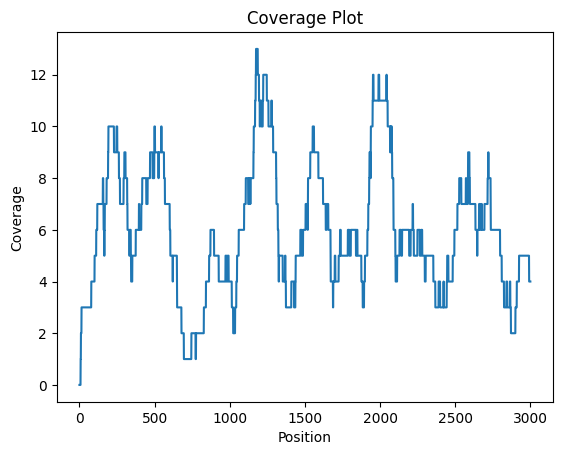

In [20]:
import sys
import os

sys.path.insert(0, os.path.abspath('../Main/lib'))

import collections
import numpy as np
from numba import jit, prange, guvectorize, int32, float32, float64
from colony import *

seq = extracting_sequence("C:\\Users\\filoa\\Desktop\\Programming_trials\\Assembler\\Main\\Data\\GCA_014117465.1_ASM1411746v1_genomic.fna")
reads = custom_reads(seq[:3000], length_reads = 150, coverage = 6, verbose=True, res_path="./")
reads = parallel_coding(reads, number_cpus=2)
print(type(reads[0][0]))

### Vectorize e Numba

@guvectorize(["int32 [:], int32[:]"], "(n) -> ()", nopython = True)
def np_score(align_list, cnt):
    """This function is a replacement for the np function np.count_nonzero(), since inside the np_eval_function was needed to count the number of zeros (=matches).
    However this function raise an error when run with the numba decorator.
    """
    cnt_ = 0

    for i in align_list:
        if i == 0:
            cnt_ += 1
    cnt[0] = cnt_

print(np_score(np.arange(2)))

@guvectorize(["int32 [:], int32[:]"], "(n) -> ()", nopython = True)
def np_score_nozeros(align_list, cnt ):
    """This function is a replacement for the np function np.count_nonzero(), since inside the np_eval_function was needed to count the number of zeros (=matches).
    However this function raise an error when run with the numba decorator.
    """
    my_len = align_list.shape[0]
    cnt_ = 0

    for i in align_list:
        if i == 0:
            cnt_ += 1

    cnt[0] = my_len - cnt_

print(np_score_nozeros(np.arange(6)))

@jit(nopython=True, parallel=True)
def np_align_func(seq_one:np.ndarray, seq_two:np.ndarray, match:int = 3, mismatch:int = -2) -> tuple:
    """This function is a replacement for the align function pirwise2.align.localms of the Bio library. This substitution has the aim of tackling the computational time of the
    eval_alignment function. In order to decrease the time, there was the need to create a compilable function with numba, which was also capable of being parallelised.
    As you can clearly see the function takes in input only the match and mismatch, because in this usage the gap introduction is useless.

    seq_one, seq_two = input sequences already trasformed in byte
    match, mismatch = integer value for the alignment

    Note: the mismatch should be negative
    Ex output: (12.0, 34, True)
    """

    # Initialization of outputs, the output is a tuple that contains: score of the alignment, a number indicating how the two reads align
    # and if the two sequences have been inverted in order during the process
    score = float(0)
    diff = 0
    switch = False

    # Since knowing which one is the longest is needed 
    if seq_one.shape[0] >= seq_two.shape[0]:
        max_lenght_seq = seq_one.shape[0]
        min_length_seq = seq_two.shape[0]

    else:
        switch = True
        max_lenght_seq = seq_two.shape[0]
        min_length_seq = seq_one.shape[0]
        seq_one, seq_two = seq_two, seq_one
    
    # Number of iterations
    num_iteration_int = (max_lenght_seq + min_length_seq - 1) // 2
    num_iteration = (max_lenght_seq + min_length_seq - 1) / 2
    alone = False

    if num_iteration > num_iteration_int:
        alone = True

    for i in prange(num_iteration_int):
        if i < min_length_seq:

            align_forw = seq_one[:(i+1)] - seq_two[-(i+1):]
            align_back = seq_two[:(i+1)] - seq_one[-(i+1):]

            cnt = 0
            for j in align_forw, align_back:
                part_score = np_score(j) * match + np_score_nozeros(j) * mismatch

                if part_score >= score:
                    score = part_score
                    if cnt > 0:
                        diff = max_lenght_seq -i -1
                    else:
                        diff = -(min_length_seq -i -1)
                cnt += 1
        
        if i >= min_length_seq:
            align_forw = seq_one[i-min_length_seq+1:(i+1)] - seq_two[-(i+1):]
            align_back = seq_one[-(i+1):-(i-min_length_seq+1)] - seq_two[:(i+1)]

            cnt = 0
            for j in align_forw, align_back:
                part_score = np_score(j) * match + np_score_nozeros(j) * mismatch

                
                if part_score >= score:
                    score = part_score
                    if cnt > 0:
                        diff = max_lenght_seq -i -1
                    else:
                        diff = -(min_length_seq -i -1)
                cnt += 1 

        if i == (num_iteration_int - 1) and alone:
            i += 1

            align_forw = seq_one[i-min_length_seq+1:(i+1)] - seq_two[-(i+1):]
            part_score = np_score(j) * match + np_score_nozeros(j) * mismatch

            if part_score >= score:
                score = part_score
                diff = max_lenght_seq -i -1


    return (score, diff, switch)


def eval_allign_np(reads:list, par:list = [3, -2]) -> np.ndarray:
    """Funtion that evaulate the alignment

    reads: list of DNA sequences, each of the read is a list of integers that resemble the real sequence

    par: list of parameters to performe the alignment
    es (the examples represent the defoult parameters):
    match_score = 3,
    mismatch_penalty = -2,

    output:
    Matrix with the weigts (distances) between the reads (nodes)
    In this matrix there are both the scores of the alignment, recognizable for the tipical integer score (even if is a float point) and
    a flaot number (like 0.23) which is needed after to recompose the sequence; it indicates the overlapping bases.
    Ex:
        allignment score -> 2.0, 13.0, ...
        overlapping number -> 0.241, 0.61, 0.561, ...
            To avoid problem later with 0 a 1 digit is added for then remove it. So 0.30 become 0.301 but the corret indices are 12 and 30.

        These two numbers are link by the position in the matrix which are the trasposition
        Score 14.0 in position (1,5) --> 0.34 in position (5,1). Only the score position is referred
        to the direction of the edge.
        1 ---> 5 with allignment score 14 and read_1 is overlapped with read_5 in positions 34 (both included)

    Example of a matrix with three reads:

        | 1    | 2    | 3    
     1  | 0    |3.0   | 0.231 
     2  | 0.601|  0   | 23.0
     3  | 18.0 | 0.701|  0
    """
    length = len(reads)
    # initialization of the matrices
    weigth_matrix = np.zeros((length, length))

    # The score of the allingment of read[1] to read[2] is the same of the opposite (read[2] to read[1])
    # So when the function found the diretionality of the allignment put the score in rigth spot and a 0 in the wrong one.
    visited = collections.deque([j for j in range(length)])
    # comb = combinations(range(len(reads)),2)
    # for i,j in comb:

    for i in tqdm(range(length)):

        for j in visited:

            if i == j:
                # the diagonal of the matrix has 0 score because we are allinging the same sequence
                continue
            else:
                # pairwise must return a positive score, if there is no one it return None
                alignment = np_align_func(reads[i], reads[j], match = par[0], mismatch = par[1])

                if alignment[2]:
                    if alignment[1] > 0:
                        weigth_matrix[j, i] = alignment[0]
                        weigth_matrix[i, j] = float(f"{0}.{abs(alignment[1])}1")
                    
                    else:
                        weigth_matrix[i, j] = alignment[0]
                        weigth_matrix[j, i] = float(f"{0}.{abs(alignment[1])}1")

                else:
                    if alignment[1] > 0:
                        weigth_matrix[i, j] = alignment[0]
                        weigth_matrix[j, i] = float(f"{0}.{abs(alignment[1])}1")
                    
                    else:
                        weigth_matrix[j, i] = alignment[0]
                        weigth_matrix[i, j] = float(f"{0}.{abs(alignment[1])}1")

                    
        visited.popleft()
    return weigth_matrix

# eval_allign_np(reads = reads)


There are 84 bases that have 0 coverage.


UnsupportedRewriteError: Failed in nopython mode pipeline (step: convert to parfors)
[1mOverwrite of parallel loop index
[1m
File "..\..\..\..\AppData\Local\Temp\ipykernel_21700\124504955.py", line 155:[0m
[1m<source missing, REPL/exec in use?>[0m
[0m

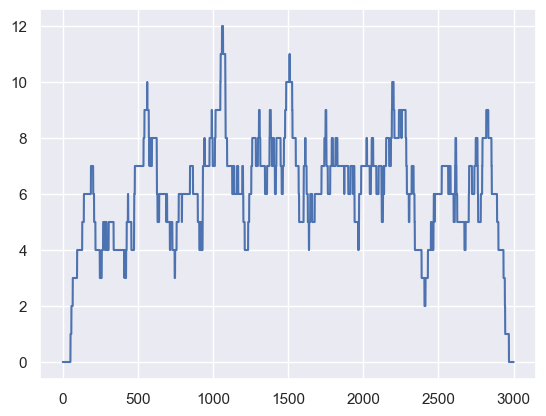

In [58]:
import sys
import os

sys.path.insert(0, os.path.abspath('../Main/lib'))

import collections
from numba import jit, prange, vectorize, float64
import numpy as np
from tqdm import tqdm
from colony import *



def tensor_score(ord_sequence:list, zeros:True)->int:
    raise NotImplemented

def tensor_align(sequence_one:str, sequence_two:str):
    raise NotImplemented

def uni_code(read:str)->np.ndarray:
    return np.array([ord(c) for c in read])

reads = comstum_reads(seq[:3000], length_reads = 150, coverage = 6, verbose=True)
reads = [uni_code(read) for read in reads]
### Parallel and delayed

@jit(nopython = True)
def np_score(align_list: np.ndarray, zeros = True)-> int:
    """This function is a replacement for the np function np.count_nonzero(), since inside the np_eval_function was needed to count the number of zeros (=matches).
    However this function raise an error when run with the numba decorator.
    """
    length = len(align_list)
    cnt = 0

    for i in align_list:
        if i == 0:
            cnt += 1

    if zeros:
        return cnt
    else:
        return length-cnt


@jit(nopython=True, parallel=True, cache=True, looplift=True)
def np_align_func(seq_one:np.ndarray, seq_two:np.ndarray, match:int = 3, mismatch:int = -2) -> tuple:
    """This function is a replacement for the align function pirwise2.align.localms of the Bio library. This substitution has the aim of tackling the computational time of the
    eval_alignment function. In order to decrease the time, there was the need to create a compilable function with numba, which was also capable of being parallelised.
    As you can clearly see the function takes in input only the match and mismatch, because in this usage the gap introduction is useless (for the moment).
    This function return only the BEST alignment.

    seq_one, seq_two = input sequences already trasformed in integers by ord function
    match, mismatch = integer value for the alignment

    Note: the mismatch should be negative
    Output: A tuple with the alignment score, a number that resamble the shift of the alignemnt, and a boolean which indicates if the order
        of the input has been inverted or not. This last element is essential to retrive the order, so which of the two will be place before the other one.
    Ex output: (12.0, 34, True)
    """

    # Initialization of outputs, the output is a tuple that contains: score of the alignment, a number indicating how the two reads align
    # and if the two sequences have been inverted in order during the process
    score = 0
    diff = 0
    switch = False

    # Since knowing which one is the longest is needed for the epoch
    if seq_one.shape[0] >= seq_two.shape[0]:
        max_lenght_seq = seq_one.shape[0]
        min_length_seq = seq_two.shape[0]

    else:
        switch = True
        max_lenght_seq = seq_two.shape[0]
        min_length_seq = seq_one.shape[0]
        seq_one, seq_two = seq_two, seq_one
    
    # Number of iterations (N + n -1)/2 because each iteration is producing two alignment one confronting the sequenvces from the forward
    # and from the backward
    num_iteration_int = (max_lenght_seq + min_length_seq - 1) // 2
    num_iteration = (max_lenght_seq + min_length_seq - 1) / 2
    alone = False # There could be needed an extra iteration if this (N + n -1)/2 is odd 

    if num_iteration > num_iteration_int:
        alone = True

    for i in prange(num_iteration_int):
        if i < min_length_seq:

            # Back/Forward alignments, only overlapping bases are being used
            align_forw = seq_one[:(i+1)] - seq_two[-(i+1):]
            align_back = seq_two[:(i+1)] - seq_one[-(i+1):]

            cnt = 0
            for j in align_forw, align_back:
                part_score = np_score(j)*match + np_score(j, zeros=False)*mismatch

                if part_score >= score:
                    score = part_score
                    if cnt > 0:
                        # If the diff value is positive the first sequence is upstream
                        # The index diff is included
                        diff = max_lenght_seq -i -1
                    else:
                        # If the diff value is negative the second sequence if the one upstream
                        # The index diff is included
                        diff = -(min_length_seq -i -1)
                cnt += 1
        
        if i >= min_length_seq:
            align_forw = seq_one[i-min_length_seq+1:(i+1)] - seq_two[-(i+1):]
            align_back = seq_one[-(i+1):-(i-min_length_seq+1)] - seq_two[:(i+1)]

            cnt = 0
            for j in align_forw, align_back:
                part_score = np_score(j)*match + np_score(j, zeros=False)*mismatch

                
                if part_score >= score:
                    score = part_score
                    if cnt > 0:
                        diff = max_lenght_seq -i -1
                    else:
                        diff = -(min_length_seq -i -1)
                cnt += 1 

        if i == (num_iteration_int - 1) and alone:
            i += 1

            align_forw = seq_one[i-min_length_seq+1:(i+1)] - seq_two[-(i+1):]
            part_score = np_score(j)*match + np_score(j, zeros=False)*mismatch

            if part_score >= score:
                score = part_score
                diff = max_lenght_seq -i -1


    return (score, diff, switch)


def eval_allign_np(reads:list, match = 3, mis_match = -2, molt = 100) -> np.ndarray:
    """Funtion that evaulate the alignment

    reads: list of DNA sequences, each of the read is a list of integers that resemble the real sequence

    par: list of parameters to performe the alignment
    es (the examples represent the defoult parameters):
    match_score = 3,
    mismatch_penalty = -2,

    output:
    Matrix with the weigts (distances) between the reads (nodes)
    In this matrix there are both the scores of the alignment, recognizable for the tipical integer score (even if is a float point) and
    a flaot number (like 0.23) which is needed after to recompose the sequence; it indicates the overlapping bases.
    Ex:
        allignment score -> 2.0, 13.0, ...
        overlapping number -> 24.1, 6.1, 56.1, ...
            To avoid problem later with 0 a 1 digit is added for then remove it. So 0.30 become 0.301 but the corret indices are 12 and 30.

        These two numbers are link by the position in the matrix which are the trasposition
        Score 14.0 in position (1,5) --> 34.1 in position (5,1). Only the score position is referred
        to the direction of the edge.
        1 ---> 5 with allignment score 14 and read_1 is overlapped with read_5 in positions 34 (both included)

    Example of a matrix with three reads:

        | 1    | 2    | 3    
     1  | 0    |3.0   | 23.1 
     2  | 60.1 |  0   | 23.0
     3  | 18.0 | 70.1 |  0
    """
    length = len(reads)
    # initialization of the matrices
    weigth_matrix = np.zeros((length, length))
    distances_matrix = np.ones((length, length))


    # The score of the allingment of read[1] to read[2] is the same of the opposite (read[2] to read[1])
    # So when the function found the diretionality of the allignment put the score in rigth spot and a 0 in the wrong one.
    visited = collections.deque([j for j in range(length)])
    # comb = combinations(range(len(reads)),2)
    # for i,j in comb:

    for i in tqdm(range(length)):

        for j in visited:

            if i == j:
                # the diagonal of the matrix has 0 score because we are allinging the same sequence
                distances_matrix[i,j] = molt*distances_matrix[i,j]
                continue
            else:
                # pairwise must return a positive score, if there is no one it return None
                alignment = np_align_func(reads[i], reads[j], match = match, mismatch = mis_match)

                if alignment[0] > 0:

                    if alignment[2]:
                        if alignment[1] > 0:
                            weigth_matrix[j, i] = alignment[0]
                            distances_matrix[j,i] = (molt*distances_matrix[i,j])/alignment[0]
                            distances_matrix[i,j] = (molt*distances_matrix[i,j])/alignment[0]
                            weigth_matrix[i, j] = float(f"{0}.{abs(alignment[1])}1")
                        
                        else:
                            weigth_matrix[i, j] = alignment[0]
                            distances_matrix[i, j] = (molt*distances_matrix[i,j])/alignment[0]
                            distances_matrix[j, i] = (molt*distances_matrix[i,j])/alignment[0]
                            weigth_matrix[j, i] = float(f"{0}.{abs(alignment[1])}1")

                    else:
                        if alignment[1] > 0:
                            weigth_matrix[i, j] = alignment[0]
                            distances_matrix[i, j] = (molt*distances_matrix[i,j])/alignment[0]
                            distances_matrix[j,i] = (molt*distances_matrix[i,j])/alignment[0]
                            weigth_matrix[j, i] = float(f"{0}.{abs(alignment[1])}1")
                        
                        else:
                            weigth_matrix[j, i] = alignment[0]
                            distances_matrix[j,i] = (molt*distances_matrix[i,j])/alignment[0]
                            distances_matrix[i,j] = (molt*distances_matrix[i,j])/alignment[0]
                            weigth_matrix[i, j] = float(f"{0}.{abs(alignment[1])}1")

                else:
                    continue

                    
        visited.popleft()
    return weigth_matrix, distances_matrix

np_score(np.arange(3))

np_align_func(reads[0], reads[1])

eval_allign_np(reads)



### Changing the final reconstruction function
- return matrix
- paralleize the coding/decoding in number
- make a separe function for the consensus
- probably is better to make lower the memory usage, since the consensus matrix will be in the same order of the length

### Graph embeddings

In [21]:
import sys
import os
sys.path.insert(0, os.path.abspath('../Main/lib'))

from numba import jit
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from scipy.io import loadmat
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt
from colony import *



def __graph_embedding__():
    """Trasform the nodes in vectors in a pre-defined space
    """
    raise NotImplemented


def __cluster_definition__():
    """Group the points (nodes/reads) in cluster to create contigs
    """
    raise NotImplemented


def cluster_link_mantainance():
    """The links between cluster represent the order of the contigs or possible high order alignments
    """    
    raise NotImplemented


def plot_dendrogram(model, plot_save_path = "./" **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0

        for child_idx in merge:

            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    plt.title("Hierarchical Clustering Dendrogram")
    dendrogram(linkage_matrix, **kwargs)
    plt.xlabel("Number of points in node (or index of point if no parenthesis).")
    plt.savefig(plot_save_path)



matrix = loadmat("C:\\Users\\filoa\\Desktop\\Programming_trials\\Assembler\\Main\\Data\\graph_metadata.mat")["data"]

# print(dist_mat)

cl = AgglomerativeClustering(compute_distances=True, distance_threshold = 0.5,  n_clusters=None, metric="precomputed", linkage="single").fit(dist_mat)

# plot the top three levels of the dendrogram
plot_dendrogram(cl, truncate_mode = "level", p=3)



NameError: name 'dist_mat' is not defined

In [208]:
from Bio import SeqIO
import matplotlib.pyplot as plt
import datetime

def extract_reads(input_path:str)-> list:

    reads = []
    for seq in SeqIO.parse(input_path, format="fastq"):
        reads.append(seq.seq.upper())

    phred_score = []
    cnt = 0

    for seq_record in SeqIO.parse(input_path, "qual"):
        phred_score.append((cnt, seq_record.letter_annotations["phred_quality"]))
        cnt +=1

    return reads, phred_score

extract_reads("C:\\Users\\filoa\\Downloads\\SRR28562905.fastq.gz")

UnicodeDecodeError: 'charmap' codec can't decode byte 0x90 in position 37: character maps to <undefined>